In [1]:
from tensorflow.python import keras
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, UpSampling2D, Cropping2D
from tensorflow.python.keras import backend as K

In [2]:
class UNet:
    
    def __init__(self, img_dim=None):
        self.img_shape = (img_dim, img_dim, 3)
    
    def Conv2D_x2_Pool(self, x, filters, pool=True):
        conv = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
        res = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(conv)
        if pool:
            out = MaxPooling2D()(res)
            return out, res
        else:
            return res
    
    def UpConv(self, x, res, filters):
        x = UpSampling2D()(x)
        conv = Conv2D(filters=filters, kernel_size=(2,2), padding='same')(x)
        cropping_size = res.get_shape().as_list()[1] - conv.get_shape().as_list()[1]
        crop = Cropping2D(cropping=cropping_size//2)(res)
        merged = Concatenate()([conv, crop])
        conv_op_1 = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(merged)
        out = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(conv_op_1)    
        return out
    
    def create_model(self):
        img = Input(shape=self.img_shape)
        filters = [64, 128, 256, 512, 1024]

        x = img
        residuals = []
        pool = True

        for fil in filters:

            if fil == 1024:
                pool = False

            if pool == True: 
                x, res = self.Conv2D_x2_Pool(x, fil, pool=pool)
                residuals.append(res)

            else:
                x = self.Conv2D_x2_Pool(x, fil, pool=pool)
        
        counter = -1
        
        for fil in reversed(filters[:-1]):

            x = self.UpConv(x, residuals[counter], fil) 
            
            counter = counter - 1
            
        out = Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid')(x)
        
        model = Model(inputs=img, outputs=out)
        
        return model

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
%matplotlib inline

In [4]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# we create two instances with the same arguments
data_gen_args = dict(rescale=1./255,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True,
                     shear_range=0.2,
                     brightness_range=(0.5, 1.0),
                     validation_split=0.2
                    )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [5]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
DATA_DIR = '../../data/raw/car/'

In [6]:
from tensorflow.python.keras.utils import multi_gpu_model
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [7]:
import tensorflow as tf

def dice_coef(y_true, y_pred):
    """
    write our own dice_coeficcient metric
    """
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    isct = tf.reduce_sum(y_true * y_pred)
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [7]:
import PIL
from PIL import Image

img_size = 256

image_args = dict(seed=seed,
    batch_size=32,
    shuffle=True,
    class_mode=None,
    target_size=(img_size, img_size),
    color_mode='rgb')

mask_args = dict(seed=seed,
    batch_size=32,
    class_mode=None,
    shuffle=True,
    target_size=(img_size, img_size), 
    color_mode='grayscale')

DIR = '../../data/raw/car/'
image = 'images'
masks = 'masks'

# combine generators into one which yields image and masks
train_generator = zip(image_datagen.flow_from_directory(**image_args, directory=DIR+'training_'+image),  
                      mask_datagen.flow_from_directory(**mask_args, directory=DIR+'training_'+masks))

validation_generator = zip(image_datagen.flow_from_directory(**image_args, directory=DIR+'validation_'+image),  
                      mask_datagen.flow_from_directory(**mask_args, directory=DIR+'validation_'+masks))



Found 4324 images belonging to 1 classes.
Found 4324 images belonging to 1 classes.
Found 509 images belonging to 1 classes.
Found 509 images belonging to 1 classes.


In [9]:
img1, mask1 = next(train_generator)

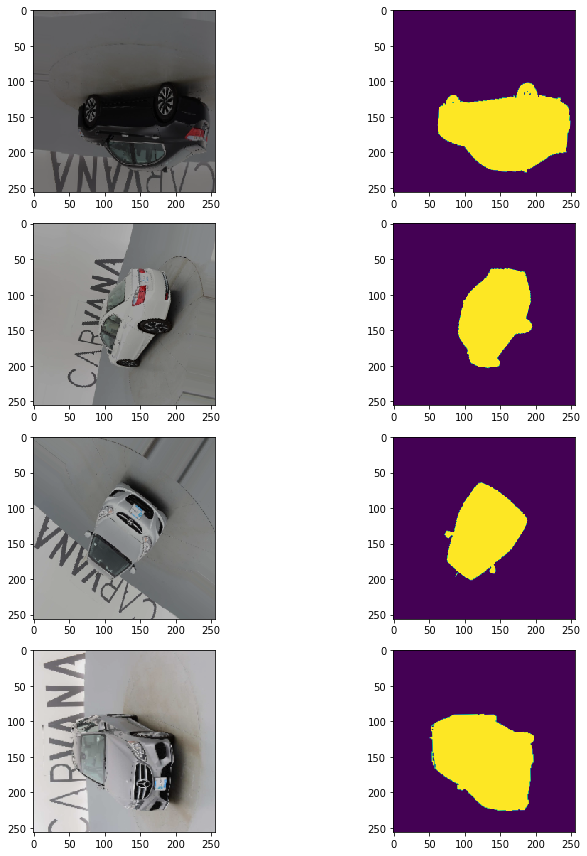

In [27]:
fig=plt.figure(figsize=(12,12))
columns = 2
rows = 4
counter = 0
c = 0
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    if counter%2 == 0:
        plt.imshow(img1[c])
    else:
        plt.imshow(mask1[c][:,:,0])
        c = c + 1
    counter = counter + 1
    

plt.tight_layout()
plt.savefig('augmented.png')
plt.show()

In [ ]:
### net = UNet(img_dim=img_size)
model = net.create_model()
parallel_model = multi_gpu_model(model, gpus=2)
#parallel_model.compile(loss='binary_crossentropy', optimizer='adam')

parallel_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy',
                  metrics=[dice_coef])

callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='./logs/logs_1e-4')]

In [ ]:
parallel_model.fit_generator(train_generator, steps_per_epoch=135, epochs=20, validation_data=validation_generator,
        validation_steps=16, callbacks=callbacks, workers=2)

Epoch 1/20
  7/135 [>.............................] - ETA: 4:01 - loss: 0.5202 - dice_coef: 0.1295

In [21]:
net = UNet(img_dim=img_size)
model = net.create_model()
parallel_model = multi_gpu_model(model, gpus=2)
filename = 'weights/weights_1e-4/best_weights.hdf5'
parallel_model.load_weights(filename)

In [25]:
img, mask = next(train_generator)

In [27]:
mask_test = parallel_model.predict(img[0][np.newaxis, :])

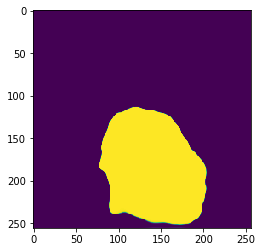

In [35]:
plt.imshow(mask_test[0,:,:,0])

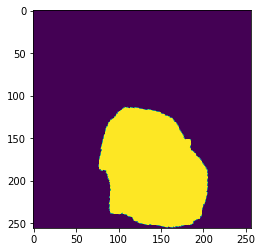

In [36]:
plt.imshow(mask[0,:,:,0])

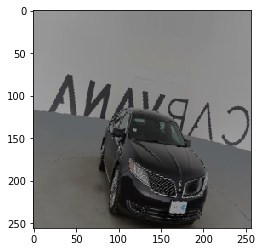

In [38]:
plt.imshow(img[0])